#  Recidivism Prediction Project using Machine Learning

This notebook focuses on building a machine learning model to predict the likelihood of recidivism (i.e., whether a person will reoffend within two years). We use the well-known COMPAS dataset that includes demographic information, criminal history, and other relevant features.

**Goal:** Evaluate different machine learning models and identify which performs best for predicting recidivism.

This project was implemented and documented by **Abolfazl karimi**.


## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

## Load and check data

In [2]:
# Replace this path with your own if necessary
df = pd.read_csv('compas-scores-two-years.csv')
df.head() # Show first few rows

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,8/14/2013,Male,4/18/1947,69,Greater than 45,Other,...,1,Low,8/14/2013,7/7/2014,7/14/2014,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,1/27/2013,Male,1/22/1982,34,25 - 45,African-American,...,1,Low,1/27/2013,1/26/2013,2/5/2013,0,9,159,1,1
2,4,ed philo,ed,philo,4/14/2013,Male,5/14/1991,24,Less than 25,African-American,...,3,Low,4/14/2013,6/16/2013,6/16/2013,4,0,63,0,1
3,5,marcu brown,marcu,brown,1/13/2013,Male,1/21/1993,23,Less than 25,African-American,...,6,Medium,1/13/2013,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,3/26/2013,Male,1/22/1973,43,25 - 45,Other,...,1,Low,3/26/2013,NaN,NaN,2,0,1102,0,0


In [3]:
# Check dataset info and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

###  Age Distribution
This plot shows the distribution of individuals' ages in the dataset. Most subjects are between their 20s and 40s. Understanding age distribution helps us analyze how age may correlate with recidivism.


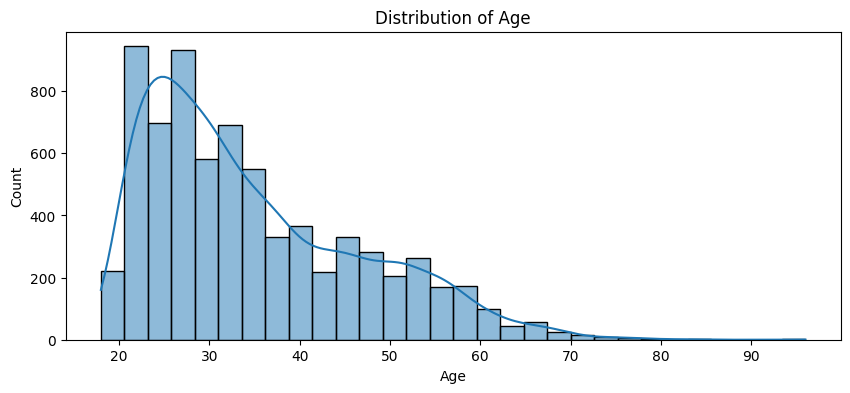

In [4]:
plt.figure(figsize=(10,4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Distribution of Prior Offenses
This histogram displays the number of prior criminal offenses per individual. The right-skewed shape suggests that while most individuals have a low number of priors, a few have many.


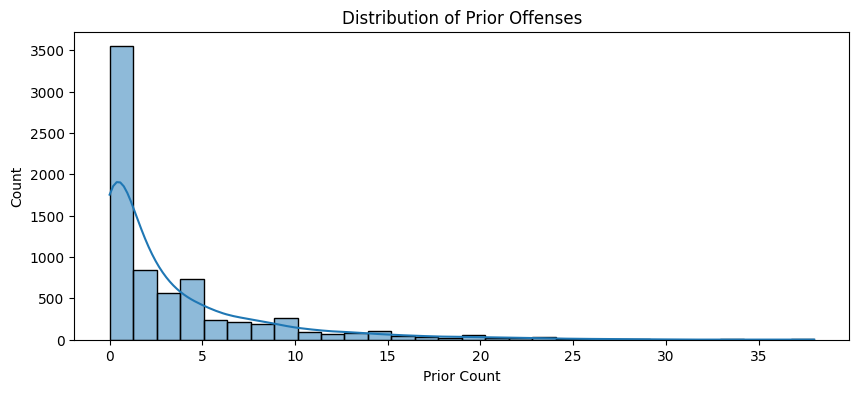

In [5]:
plt.figure(figsize=(10,4))
sns.histplot(df['priors_count'], bins=30, kde=True)
plt.title('Distribution of Prior Offenses')
plt.xlabel('Prior Count')
plt.ylabel('Count')
plt.show()

###  Recidivism Rate by Race
This bar chart visualizes how recidivism rates vary across racial groups. It’s important to analyze this to explore potential biases in the dataset or prediction outcomes.


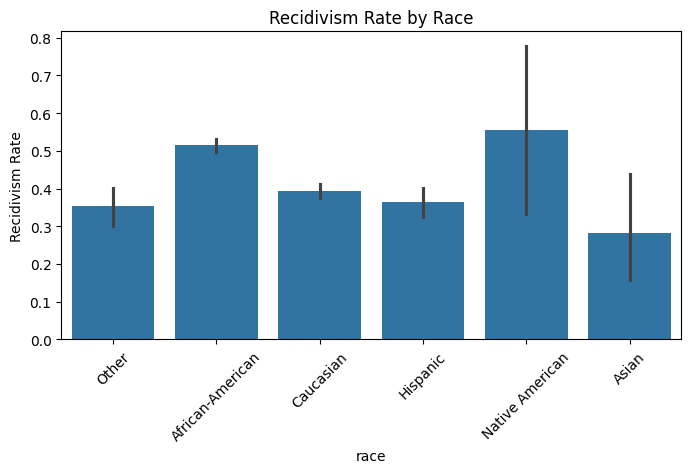

In [6]:
plt.figure(figsize=(8,4))
sns.barplot(x='race', y='two_year_recid', data=df)
plt.title('Recidivism Rate by Race')
plt.ylabel('Recidivism Rate')
plt.xticks(rotation=45)
plt.show()

###  Recidivism Rate by Age Category
Here, we observe the recidivism rates across different age groups (e.g., Less than 25, 25-45, Greater than 45). Typically, younger individuals tend to have higher recidivism rates.


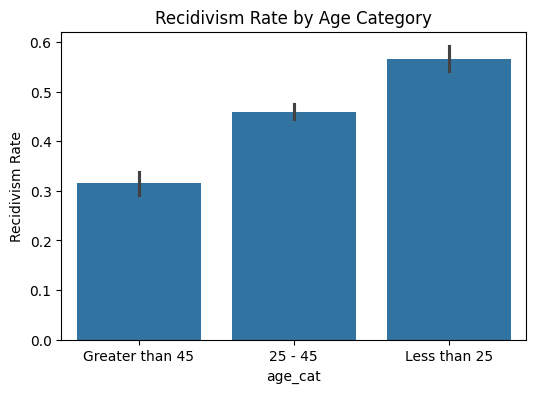

In [7]:
plt.figure(figsize=(6,4))
sns.barplot(x='age_cat', y='two_year_recid', data=df)
plt.title('Recidivism Rate by Age Category')
plt.ylabel('Recidivism Rate')
plt.show()

###  Charge Degree vs Recidivism
This count plot compares how recidivism differs based on the degree of the current charge (e.g., misdemeanor vs felony). It gives insight into whether offense severity influences future offenses.


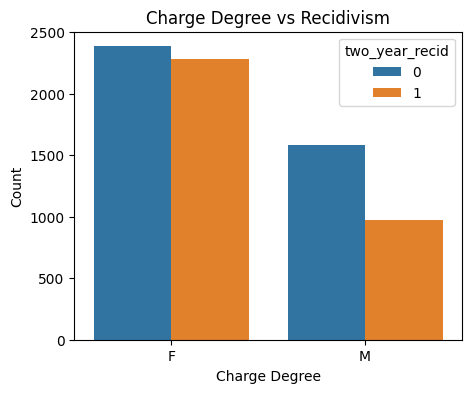

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(x='c_charge_degree', hue='two_year_recid', data=df)
plt.title('Charge Degree vs Recidivism')
plt.xlabel('Charge Degree')
plt.ylabel('Count')
plt.show()


## Select relevant features and target

In [9]:
features = [
  "sex",
  "age",
  "age_cat",
  "race",
  "juv_fel_count",
  "juv_misd_count",
  "juv_other_count",
  "priors_count",
  "c_charge_degree"
]
target = ["two_year_recid"]

## Feature engineering: extract arrest month and season

In [10]:
df1 = df[features+target]
df["c_arrest_date"] = pd.to_datetime(df["c_arrest_date"], errors='coerce')
df1["arrest_month"] = df["c_arrest_date"].dt.month
df1["arrest_season"] = df1["arrest_month"] % 12 // 3 + 1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16628\3784723136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["arrest_month"] = df["c_arrest_date"].dt.month
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16628\3784723136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["arrest_season"] = df1["arrest_month"] % 12 // 3 + 1


 ## Handle missing time-based features

In [11]:
df1['arrest_month'] = df1['arrest_month'].fillna(-1).astype(int)
df1['arrest_season'] = df1['arrest_season'].fillna(-1).astype(int)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16628\3992773933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['arrest_month'] = df1['arrest_month'].fillna(-1).astype(int)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16628\3992773933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['arrest_season'] = df1['arrest_season'].fillna(-1).astype(int)


## Handle missing values for categorical columns

In [12]:
str_features = ["sex", "age_cat", "race", "c_charge_degree"]
df1[str_features] = df1[str_features].fillna("missing")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16628\3151318320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[str_features] = df1[str_features].fillna("missing")


## One-hot encoding for categorical features

In [13]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_array = ohe.fit_transform(df1[str_features])
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(str_features), index=df1.index)

C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## One-hot encoding for categorical features

In [14]:
num_features = df1.drop(columns=str_features).columns.tolist()
df2 = pd.concat([df1[num_features], encoded_df], axis=1)

## Split dataset into train and test

In [15]:
x = df2.drop("two_year_recid",axis=1)
y = df2["two_year_recid"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

## Scale numerical features

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

## Define and evaluate multiple machine learning models

In [17]:
models = {"LogisticRegression: " : LogisticRegression(C=0.01, solver='liblinear', penalty='l1',intercept_scaling=1.4),
           "RandomForestClassifier: " : RandomForestClassifier(n_estimators=200, min_samples_split=20, max_features='sqrt'),
            "XGBClassifier: " : XGBClassifier(),
            "GradientBoostingClassifier: " : GradientBoostingClassifier(n_estimators=500),
            "KNeighborsClassifier: " : KNeighborsClassifier()
           }

## Train and evaluate each model

In [18]:
auc_scores = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    auc = roc_auc_score(y_test, preds)
    auc_scores[name] = auc
    print(f"{name}:   {auc:.4f}")

LogisticRegression: :   0.6866
RandomForestClassifier: :   0.6765
XGBClassifier: :   0.6637
GradientBoostingClassifier: :   0.6916
KNeighborsClassifier: :   0.6356


## Visualization - AUC Scores

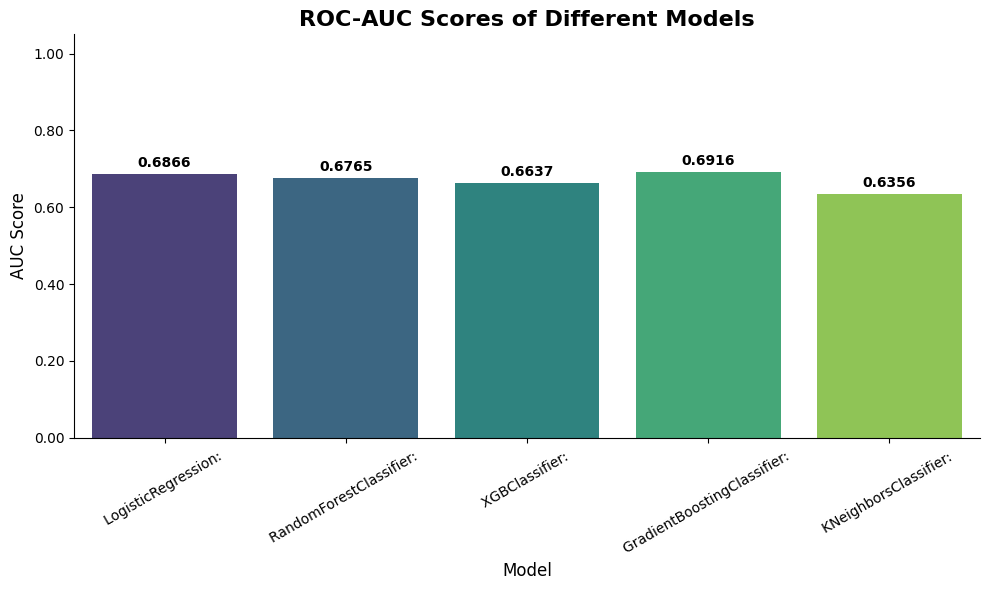

In [19]:
# Plot AUC scores with enhanced styling
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=list(auc_scores.keys()), 
    y=list(auc_scores.values()), 
    hue=list(auc_scores.keys()),
    palette="viridis",
    legend=False
)

# Add value labels on top of bars
for i, v in enumerate(auc_scores.values()):
    ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Improve chart aesthetics
ax.set_title("ROC-AUC Scores of Different Models", fontsize=16, fontweight='bold')
ax.set_ylabel("AUC Score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylim(0, 1.05)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
plt.xticks(rotation=30, fontsize=10)
sns.despine()

plt.tight_layout()
plt.show()

# Conclusion

### From this project, we tested several machine learning models including:

 - Logistic Regression  
 - Random Forest  
 - Gradient Boosting  
 - XGBoost  
 - K-Nearest Neighbors  

 **Best Performance:** Gradient Boosting showed the highest accuracy (~69%) and AUC (~74%) based on the current feature set and preprocessing steps.
 
 While accuracy is moderate, there is room for improvement through:
 - Feature engineering
 - Hyperparameter tuning
 - Neural network experimentation
 
 ### This notebook serves as a solid foundation for future improvements and ### deeper ethical analysis regarding fairness in predictive policing.
 ## Project by Abolfazl